In [1]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')

In [2]:
import GCRCatalogs
import numpy as np
import healsparse as hsp
import healpy as hp
import matplotlib.pyplot as plt

In [3]:
from GCR import GCRQuery
catalog = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns_with_photoz')

In [4]:
bands = ['u','g','r','i','z','y']

# conditions under "WHERE" and under "if strict_cuts" in pdr1_queries.py#L113
strict_cuts = [
    GCRQuery('detect_isPrimary'),
    GCRQuery('modelfit_CModel_flag_badCentroid==False'),
    GCRQuery('base_SdssCentroid_flag==False'),
    GCRQuery('base_PsfFlux_flag==False'),
    GCRQuery('deblend_skipped==False')
#     GCRQuery('clean')
#     GCRQuery('base_PixelFlags_flag_edge==False'),
#     GCRQuery('base_PixelFlags_flag_interpolatedCenter==False'),
#     GCRQuery('base_PixelFlags_flag_saturatedCenter==False'),
#     GCRQuery('base_PixelFlags_flag_crCenter==False'),
#     GCRQuery('base_PixelFlags_flag_bad==False'),
#     GCRQuery('base_PixelFlags_flag_suspectCenter==False'),
#     GCRQuery('base_PixelFlags_flag_clipped==False'),
]
for b in bands:
    strict_cuts.append(GCRQuery('cModelFlux_flag_%s==False'%b))
    strict_cuts.append(GCRQuery('%s_base_SdssCentroid_flag==False'%b)),
    strict_cuts.append(GCRQuery('%s_base_PixelFlags_flag_edge==False'%b)),
    strict_cuts.append(GCRQuery('%s_base_PixelFlags_flag_interpolatedCenter==False'%b)),
    strict_cuts.append(GCRQuery('%s_base_PixelFlags_flag_saturatedCenter==False'%b)),
    strict_cuts.append(GCRQuery('%s_base_PixelFlags_flag_crCenter==False'%b)),
    strict_cuts.append(GCRQuery('%s_base_PixelFlags_flag_bad==False'%b)),
    strict_cuts.append(GCRQuery('%s_base_PixelFlags_flag_suspectCenter==False'%b)),
    strict_cuts.append(GCRQuery('%s_base_PixelFlags_flag_clipped==False'%b))
    
# conditions under "WHERE" and above "if strict_cuts" in pdr1_queries.py#L113    
standard_cuts =[
    GCRQuery('detect_isPrimary'),
    GCRQuery('i_modelfit_CModel_flag_badCentroid==False'),
    GCRQuery('i_base_SdssCentroid_flag==False'),
    GCRQuery('i_base_PixelFlags_flag_edge==False'),
    GCRQuery('i_base_PixelFlags_flag_interpolatedCenter==False'),
    GCRQuery('i_base_PixelFlags_flag_saturatedCenter==False'),
    GCRQuery('i_base_PixelFlags_flag_crCenter==False'),
    GCRQuery('i_base_PixelFlags_flag_bad==False'),
    GCRQuery('i_base_PixelFlags_flag_suspectCenter==False'),
    GCRQuery('i_base_PixelFlags_flag_clipped==False'),
    GCRQuery('deblend_skipped==False')
]

# additional cuts under reduce_cat.py#L151
blend_cut = [
    GCRQuery('base_Blendedness_abs_instFlux<=0.42169650342')
]

depth_cut=[
    GCRQuery('mag_i_cModel<=24.5')    
]

gal_cut=[
    GCRQuery('i_base_ClassificationExtendedness_value>0.99')
]

# snr and mag should be finite
snrnan_cut = [GCRQuery((np.isfinite, 'snr_%s_cModel'%band)) for band in bands]
magnan_cut = [GCRQuery((np.isfinite, 'mag_%s_cModel'%band)) for band in bands]

In [5]:
# mask of total flux cut under reduce_cat.py#L151
def flux_mask(data_cut):
    ugrzy = ['u','g','r','z','y']
    ugrzy_mask = np.zeros(len(data_cut['ra']))
    for band in ugrzy:
        ugrzy_mask += GCRQuery('snr_%s_cModel > 5'%band).mask(data_cut)
    ugrzy_mask = ugrzy_mask>1
    i_mask = GCRQuery('snr_i_cModel > 10').mask(data_cut)

    return ugrzy_mask*i_mask

In [6]:
# pz distribution of the data cut
def plot_pz(data_cut, bin_centers):
    sumpdf = np.sum(data_cut['photoz_pdf'][flux_mask(data_cut)],axis=0)
    plt.hist(data_cut['photoz_mode'][flux_mask(data_cut)], 100, label="photo-z mode");
    plt.plot(bin_centers, sumpdf,label="summed $p(z)$");
    plt.xlabel("redshift");
    plt.legend(loc='upper left');

In [7]:
def nobj_map(ra, dec, nsideSparse):
    pix_nums = hp.ang2pix(nsideSparse, np.radians(90-dec), np.radians(ra), nest=True)
    pix_uni, nobj = np.unique(pix_nums, return_counts=True)
    
    dtype = [('nobj','float')]    
    rec_mp = np.rec.fromarrays([nobj], dtype=dtype)
    hsp_mp = hsp.HealSparseMap.makeEmpty(32, nsideSparse, dtype=dtype, primary='out')
    hsp_mp.updateValues(pix_uni, rec_mp)
    
    return hsp_mp

In [8]:
snrs = ['snr_%s_cModel'%band for band in bands]
mags = ['mag_%s_cModel'%band for band in bands]

In [9]:
# Loads the data after cut
data_cut = catalog.get_quantities(['ra', 'dec', 'photoz_pdf', 'photoz_mode'] + snrs + mags, 
                                  filters = standard_cuts+snrnan_cut+magnan_cut
                                  +blend_cut+depth_cut+gal_cut
                                 )

In [10]:
ra, dec = data_cut['ra'][flux_mask(data_cut)], data_cut['dec'][flux_mask(data_cut)]
# ra, dec = data_cut['ra'], data_cut['dec']
len(ra)

534601

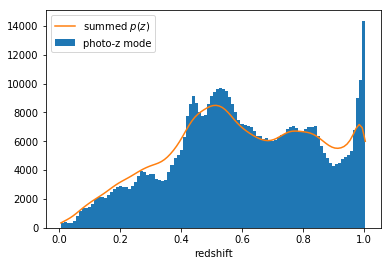

In [11]:
plot_pz(data_cut, catalog.photoz_pdf_bin_centers)

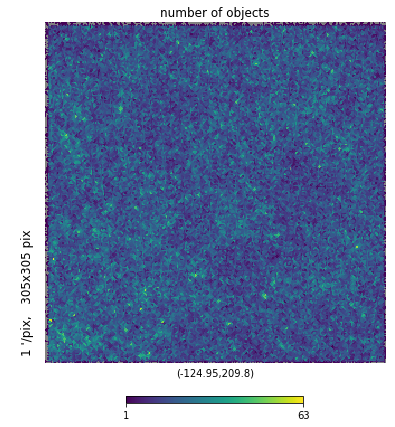

In [12]:
hsp_mp = nobj_map(ra,dec,2048)
rec_hp = hsp_mp.generateHealpixMap(nside=2048, key='nobj')
hp.gnomview(rec_hp, rot = [55.05-180,180+29.80], reso=1, xsize=305, title='number of objects', nest=True)